# DACON : 신용카드 사용자 연체 예측 AI 경진대회

## Import

In [1]:
#!pip3 install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 99)

In [3]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical
import random

In [4]:
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')

from IPython.display import IFrame
import chart_studio.plotly as py
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.io as pio

from pyecharts.globals import ThemeType
from pyecharts.commons.utils import JsCode
from pyecharts.charts import Bar, Bar3D, Grid, Line, Liquid, Page, Pie, Timeline, Tab, Map, Grid
from pyecharts import options as opts

import folium, webbrowser, IPython, warnings
warnings.filterwarnings('ignore')

## Data Load

In [5]:
train = pd.read_csv('train.csv')

###  데이터 확인

In [6]:
display(train.head(2))
display(train.tail(2))

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0
26456,26456,F,N,N,0,81000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-19569,-1013,1,0,0,0,Security staff,2.0,-9.0,2.0


In [7]:
train.shape

(26457, 20)

In [8]:
train = train.drop(["index"], axis=1)

### 데이터 변수 설명
index


gender: 성별


car: 차량 소유 여부


reality: 부동산 소유 여부


child_num: 자녀 수


income_total: 연간 소득


income_type: 소득 분류


['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']



edu_type: 교육 수준


['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']



family_type: 결혼 여부


['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']



house_type: 생활 방식


['Municipal apartment', 'House / apartment', 'With parents',

'Co-op apartment', 'Rented apartment', 'Office apartment']



DAYS_BIRTH: 출생일


데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미



DAYS_EMPLOYED: 업무 시작일


데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미

양수 값은 고용되지 않은 상태를 의미함



FLAG_MOBIL: 핸드폰 소유 여부


work_phone: 업무용 전화 소유 여부


phone: 전화 소유 여부


email: 이메일 소유 여부


occyp_type: 직업 유형


family_size: 가족 규모


begin_month: 신용카드 발급 월
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미







credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도


=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

### 변수 중요도 함수

In [9]:
# 변수 중요도 함수
'''
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
'''

"\ndef plot_feature_importance(importance,names,model_type):\n    \n    feature_importance = np.array(importance)\n    feature_names = np.array(names)\n    \n    data={'feature_names':feature_names,'feature_importance':feature_importance}\n    fi_df = pd.DataFrame(data)\n    \n    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)\n\n    plt.figure(figsize=(10,8))\n\n    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])\n\n    plt.title(model_type + ' Feature Importance')\n    plt.xlabel('Feature Importance')\n    plt.ylabel('Feature Names')\n"

## EDA

###  각 데이터의 타입 확인

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

###  결측치 확인하기

In [11]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [12]:
!pip install missingno

<AxesSubplot:>

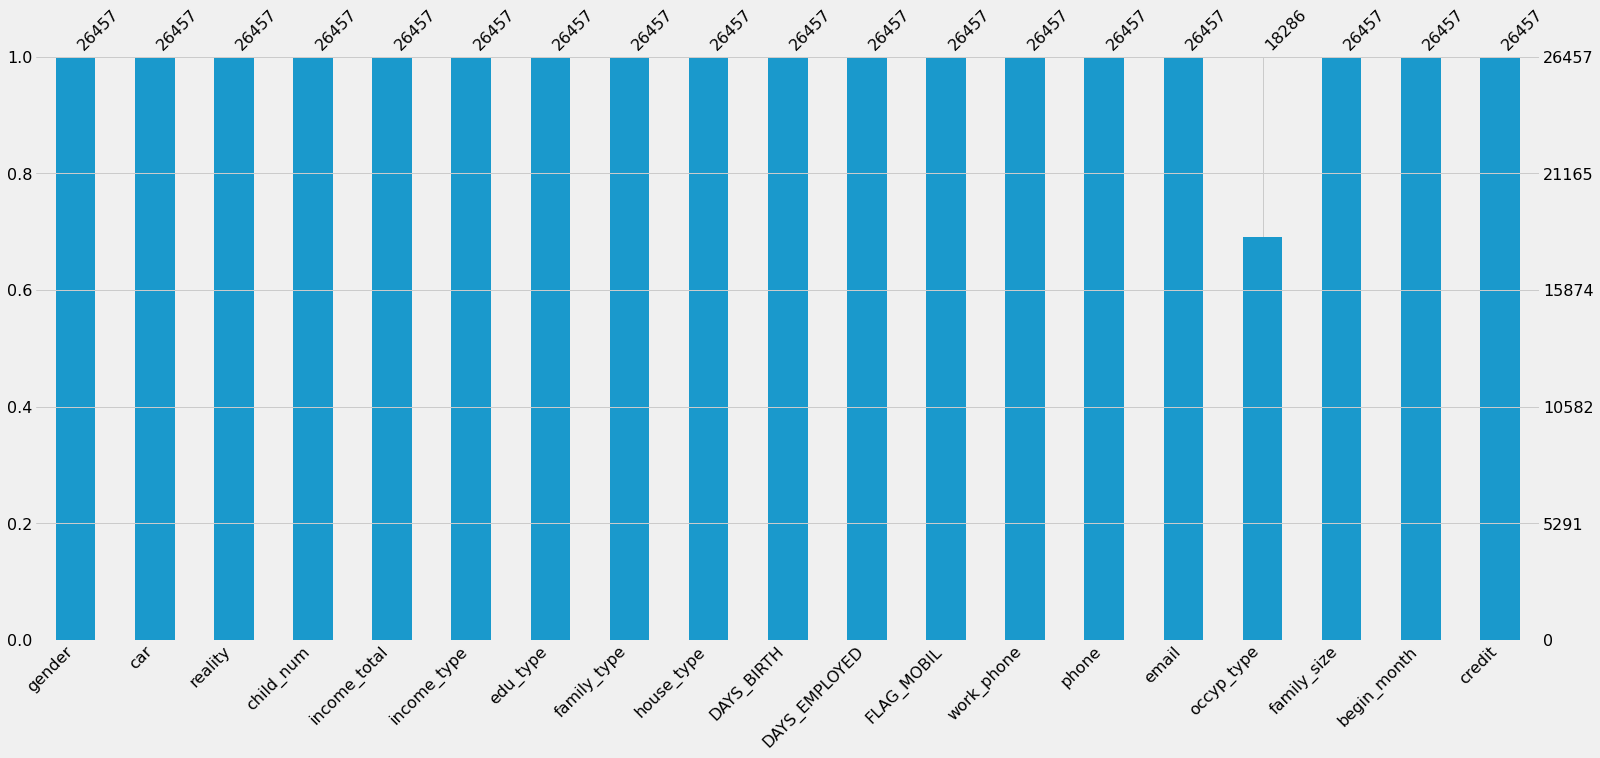

In [13]:
import missingno as msno
msno.bar(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

### 결측치 처리(loss 작은쪽 선택)

In [14]:
#NA Imputation
train = train.fillna({'occyp_type':'NA'})

### 이상치 제거

In [15]:
# family_size 이상치 제거
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

## FE


### binary

In [16]:
'''
#gender, car, reality는 binary(object)

train['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0
train['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
train['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
'''

"\n#gender, car, reality는 binary(object)\n\ntrain['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0\ntrain['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0\ntrain['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0\n"

### categorical

In [17]:
'''
#라벨인코딩
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()

train['income_type'] = enc.fit_transform(train['income_type'])
train['edu_type'] = enc.fit_transform(train['edu_type'])
train['family_type'] = enc.fit_transform(train['family_type'])
train['house_type'] = enc.fit_transform(train['house_type'])
train['occyp_type'] = enc.fit_transform(train['occyp_type'])
'''

"\n#라벨인코딩\nfrom sklearn import preprocessing\nenc = preprocessing.LabelEncoder()\n\ntrain['income_type'] = enc.fit_transform(train['income_type'])\ntrain['edu_type'] = enc.fit_transform(train['edu_type'])\ntrain['family_type'] = enc.fit_transform(train['family_type'])\ntrain['house_type'] = enc.fit_transform(train['house_type'])\ntrain['occyp_type'] = enc.fit_transform(train['occyp_type'])\n"

### numerical

In [18]:
#음수값을 양수값으로 
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x: -x)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: -x)
train['begin_month'] = train['begin_month'].apply(lambda x: -x)

In [19]:
# DAYS_EMPLOYED < 0  -> 0으로 변환, year_employed 생성
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: x if x >=0 else 0)
train['year_employed'] = train['DAYS_EMPLOYED'] / 365
train['year_employed'] = train['year_employed'].astype('int')
#train = train.drop('DAYS_EMPLOYED', axis=1)

In [20]:
#DAYS_BIRTH로 나이 변수 만들어주기
train['age'] = abs(train['DAYS_BIRTH'])/365
train = train.astype({'age': 'int'})
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,year_employed,age
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,1,0,0,0,NA,2.0,6.0,1.0,12,38
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,1,0,0,1,Laborers,3.0,5.0,1.0,4,31
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,1,0,1,0,Managers,2.0,22.0,2.0,12,52
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,1,0,1,0,Sales staff,2.0,37.0,0.0,5,41
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,1,0,0,0,Managers,2.0,26.0,2.0,5,41


In [21]:
# start_work 추가
train['start_work'] = train['age'] - train['year_employed']

In [22]:
train = train.astype({'begin_month':'int', 'family_size':'int', 'income_total':'int'})

In [23]:
# 소득/나이 비율, 소득/ 일한 기간 비율

train['income_age'] = train['income_total'] / train['age']
train['income_employed'] = train['income_total'] / (train['year_employed'] + 1)

In [24]:
# 소득/ 가족 수 비율
train['income_family'] = train['income_total'] / train['family_size']

###  종속변수
해당 대회는 credit을 예측하는 것이 목적
즉 credit 값이 종속변수, 다른 값들이 독립변수

In [25]:
train['credit'].unique() 
#0,1,2가 credit
#낮을 수록 높은 신용의 신용카드 사용자를 의미함 

array([1., 2., 0.])

In [26]:
train['credit'] = train['credit'].astype('str')

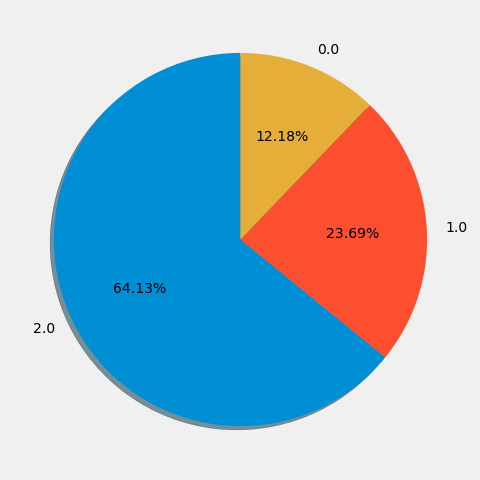

In [27]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.show()

### scaling

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sca = StandardScaler()

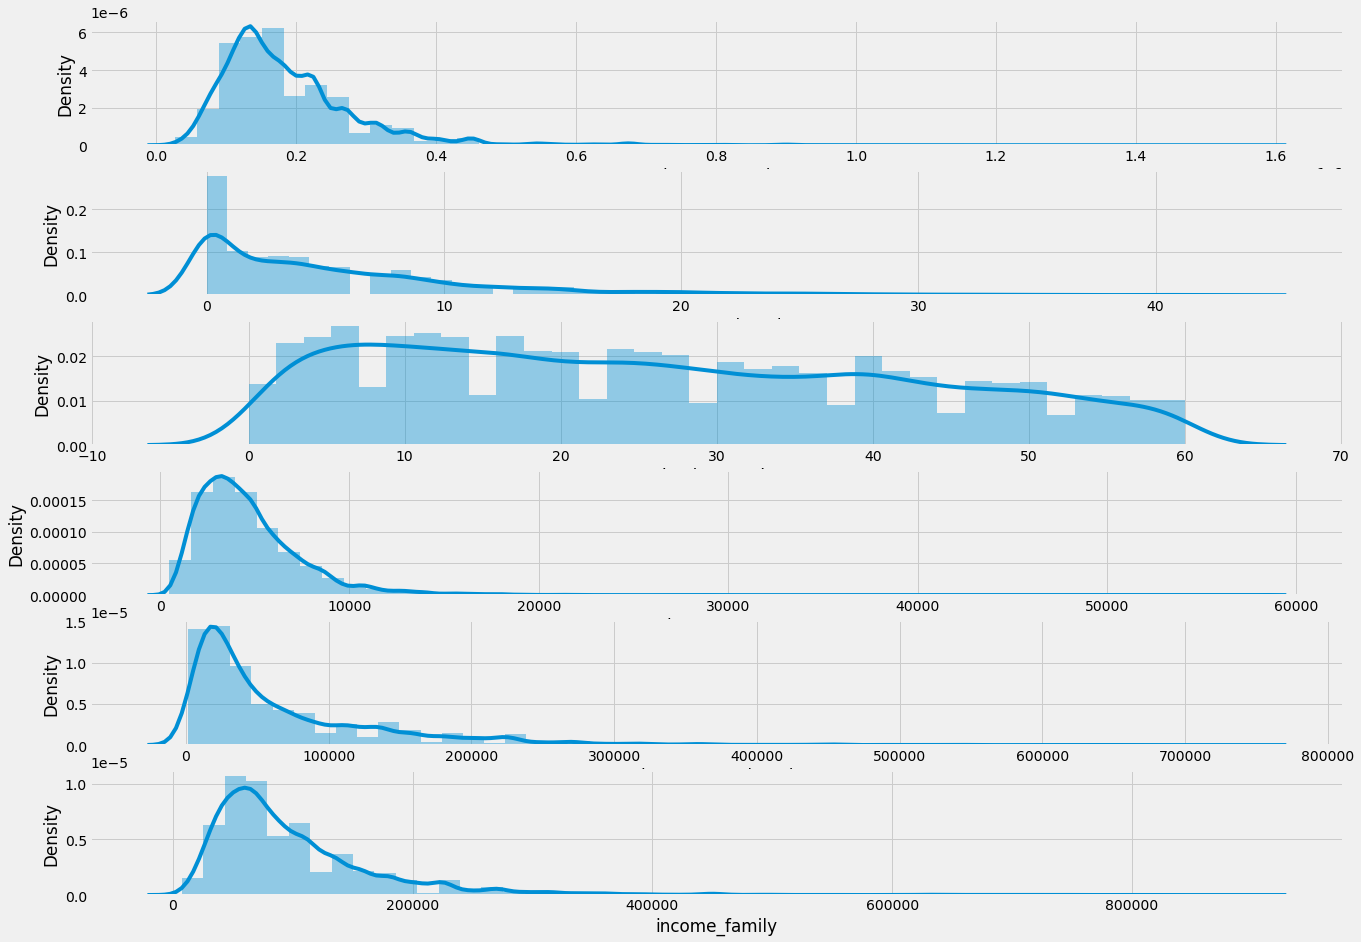

In [29]:
columns = ['income_total', 'year_employed', 'begin_month','income_age','income_employed','income_family']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,15))
for i in range(6):
    plt.subplot(6,1,i+1)
    sns.distplot(train[columns[i]])
plt.show()

In [30]:
'''
train['income_total'] = sca.fit_transform(train[['income_total']])
train['year_employed'] = sca.fit_transform(train[['year_employed']])
#train['Age'] = sca.fit_transform(train[['Age']])
train['begin_month'] = sca.fit_transform(train[['begin_month']])
#train['start_work'] = sca.fit_transform(train[['start_work']])
train['income_age'] = sca.fit_transform(train[['income_age']])
train['income_employed'] = sca.fit_transform(train[['income_employed']])
train['income_family'] = sca.fit_transform(train[['income_family']])
'''

"\ntrain['income_total'] = sca.fit_transform(train[['income_total']])\ntrain['year_employed'] = sca.fit_transform(train[['year_employed']])\n#train['Age'] = sca.fit_transform(train[['Age']])\ntrain['begin_month'] = sca.fit_transform(train[['begin_month']])\n#train['start_work'] = sca.fit_transform(train[['start_work']])\ntrain['income_age'] = sca.fit_transform(train[['income_age']])\ntrain['income_employed'] = sca.fit_transform(train[['income_employed']])\ntrain['income_family'] = sca.fit_transform(train[['income_family']])\n"

### 변수별 상관관계

<AxesSubplot:>

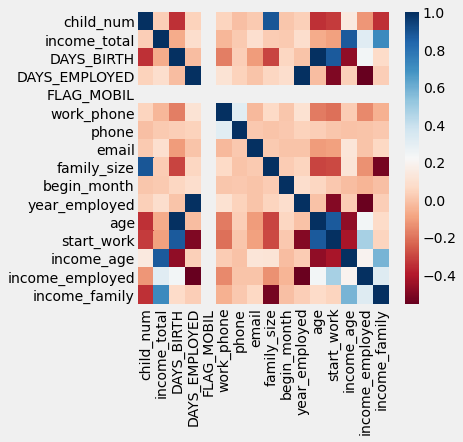

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(5,5))
corr = train.corr()
sns.heatmap(corr,cmap='RdBu')

### 변수 제거 / 합치기

In [32]:
# child_num 제거
train = train.drop('child_num', axis=1)

In [33]:
train = train.drop('year_employed', axis=1)
#train = train.drop('DAYS_EMPLOYED', axis=1)
train = train.drop('DAYS_BIRTH', axis=1)
train = train.drop('FLAG_MOBIL', axis=1)

In [34]:
train['e_p'] = train['email'] + train['work_phone'] + train['phone']

## 전처리 완료된 train 데이터 불러오기

In [35]:
train.head(3)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,start_work,income_age,income_employed,income_family,e_p
0,F,N,N,202500,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,NA,2,6,1.0,38,26,5328.947368,15576.923077,101250.0,0
1,F,N,Y,247500,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3,5,1.0,31,27,7983.870968,49500.000000,82500.0,1
2,M,Y,Y,450000,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2,22,2.0,52,40,8653.846154,34615.384615,225000.0,1


In [36]:
train['occyp_type'].nunique()

19

## 시각화

In [37]:
## income_type / edu_type / family_type/ house_type

train_0 = train[train['credit'] == '0.0']
train_1 = train[train['credit'] == '1.0']
train_2 = train[train['credit'] == '2.0']

In [38]:
zeroonetwo = train['credit'].value_counts()
zeroonetwo = pd.DataFrame(zeroonetwo)
zeroonetwo.rename(columns = {'credit' : 'count'}, inplace = True)
zeroonetwo.index.name = 'income_type'

zeroonetwo

,count
income_type,
2.0,16962
1.0,6267
0.0,3222


In [39]:
credit_incometype = pd.DataFrame(train.groupby([train["credit"], train["income_type"]])['income_type'].count())
credit_incometype.rename(columns = {'income_type' : 'count'}, inplace = True)
credit_incometype =credit_incometype.reset_index(['credit','income_type'])
credit_incometype

,credit,income_type,count
0,0.0,Commercial associate,782
1,0.0,Pensioner,536
2,0.0,State servant,265
3,0.0,Working,1639
4,1.0,Commercial associate,1344
5,1.0,Pensioner,1084
6,1.0,State servant,489
7,1.0,Student,3
8,1.0,Working,3347
9,2.0,Commercial associate,4076


In [40]:
credit_edu_type = pd.DataFrame(train.groupby([train["credit"], train["edu_type"]])['edu_type'].count())
credit_edu_type.rename(columns = {'edu_type' : 'count'}, inplace = True)
credit_edu_type =credit_edu_type.reset_index(['credit','edu_type'])
credit_edu_type

,credit,edu_type,count
0,0.0,Academic degree,2
1,0.0,Higher education,909
2,0.0,Incomplete higher,114
3,0.0,Lower secondary,28
4,0.0,Secondary / secondary special,2169
5,1.0,Academic degree,7
6,1.0,Higher education,1751
7,1.0,Incomplete higher,246
8,1.0,Lower secondary,59
9,1.0,Secondary / secondary special,4204


In [41]:
credit_family_type = pd.DataFrame(train.groupby([train["credit"], train["family_type"]])['family_type'].count())
credit_family_type.rename(columns = {'family_type' : 'count'}, inplace = True)
credit_family_type =credit_family_type.reset_index(['credit','family_type'])
credit_family_type

,credit,family_type,count
0,0.0,Civil marriage,288
1,0.0,Married,2213
2,0.0,Separated,193
3,0.0,Single / not married,402
4,0.0,Widow,126
5,1.0,Civil marriage,539
6,1.0,Married,4140
7,1.0,Separated,349
8,1.0,Single / not married,940
9,1.0,Widow,299


In [42]:
credit_house_type = pd.DataFrame(train.groupby([train["credit"], train["house_type"]])['house_type'].count())
credit_house_type.rename(columns = {'house_type' : 'count'}, inplace = True)
credit_house_type =credit_house_type.reset_index(['credit','house_type'])
credit_house_type

,credit,house_type,count
0,0.0,Co-op apartment,14
1,0.0,House / apartment,2873
2,0.0,Municipal apartment,110
3,0.0,Office apartment,24
4,0.0,Rented apartment,50
5,0.0,With parents,151
6,1.0,Co-op apartment,30
7,1.0,House / apartment,5569
8,1.0,Municipal apartment,160
9,1.0,Office apartment,48


In [43]:
credit_edu_type['credit'].unique()

array(['0.0', '1.0', '2.0'], dtype=object)

In [44]:
#0
x_data = zeroonetwo.index
y_data = zeroonetwo['count']
pie1 = (Pie(init_opts=opts.InitOpts(theme=ThemeType.WESTEROS))
    .add(series_name="  ",data_pair=[list(z) for z in zip(x_data, y_data)],radius=["30%", "70%"],label_opts=opts.LabelOpts(is_show=True, position="bottom"),)
    .set_global_opts(title_opts=opts.TitleOpts(title="CREDIT"),legend_opts=opts.LegendOpts(pos_left="left", pos_top="30",orient="vertical"))
    .set_series_opts(tooltip_opts=opts.TooltipOpts(trigger="item",  formatter="{a}{b}: {c} ({d}%)")))
pie1.render('credit.html')

'C:\\Users\\shong\\Documents\\credit.html'

In [45]:
from IPython.display import IFrame

IFrame(src='./credit.html', width=800, height=500)

In [46]:
categorical_tab = Tab()
#1
kind = credit_incometype['income_type'].unique()
credit_income = Timeline(init_opts=opts.InitOpts(theme=ThemeType.LIGHT, height='500px',width='1000px')).add_schema(is_auto_play=True) 
for t in credit_incometype['credit'].unique():
  credit_income.add((Pie(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
                    .add("", [list(z) for z in zip(kind,  credit_incometype[ credit_incometype['credit'] == t]['count'])],
                    rosetype="radius",radius=["30%", "60%"],
                    label_opts=opts.LabelOpts(position='outside', formatter="{b}\n{d}%"))
         .set_global_opts(title_opts=opts.TitleOpts("신용등급별 소득분류", pos_left="center"),
                          legend_opts=opts.LegendOpts(type_ = 'scroll',pos_top ="5%",orient="horizontal",legend_icon ='pin'))),"{}등급".format(t))

#2
kind = credit_edu_type['edu_type'].unique()
credit_edu = Timeline(init_opts=opts.InitOpts(theme=ThemeType.MACARONS, height='500px',width='1000px')).add_schema(is_auto_play=True) 
for t in credit_edu_type['credit'].unique():
  credit_edu.add((Pie(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
                    .add("", [list(z) for z in zip(kind, credit_edu_type[credit_edu_type['credit'] == t]['count'])],
                    rosetype="radius",radius=["30%", "60%"],
                    label_opts=opts.LabelOpts(position='outside', formatter="{b}\n{d}%"))
         .set_global_opts(title_opts=opts.TitleOpts("신용등급별 교육수준", pos_left="center"),
                          legend_opts=opts.LegendOpts(type_ = 'scroll',pos_top ="5%",orient="horizontal",legend_icon ='pin'))),"{}등급".format(t))


#3
kind = credit_family_type['family_type'].unique()
credit_family = Timeline(init_opts=opts.InitOpts(theme=ThemeType.LIGHT, height='500px',width='1000px')).add_schema(is_auto_play=True) 
for t in credit_family_type['credit'].unique():
  credit_family.add((Pie(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
                    .add("", [list(z) for z in zip(kind, credit_family_type[credit_family_type['credit'] == t]['count'])],
                    rosetype="radius",radius=["30%", "60%"],
                    label_opts=opts.LabelOpts(position='outside', formatter="{b}\n{d}%"))
         .set_global_opts(title_opts=opts.TitleOpts("신용등급별 결혼여부", pos_left="center"),
                          legend_opts=opts.LegendOpts(type_ = 'scroll',pos_top ="5%",orient="horizontal",legend_icon ='pin'))),"{}등급".format(t))

#4
kind = credit_house_type['house_type'].unique()
credit_house = Timeline(init_opts=opts.InitOpts(theme=ThemeType.LIGHT, height='500px',width='1000px')).add_schema(is_auto_play=True) 
for t in credit_house_type['credit'].unique():
  credit_house.add((Pie(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
                    .add("", [list(z) for z in zip(kind,  credit_house_type[credit_house_type['credit'] == t]['count'])],
                    rosetype="radius",radius=["30%", "60%"],
                    label_opts=opts.LabelOpts(position='outside', formatter="{b}\n{d}%"))
         .set_global_opts(title_opts=opts.TitleOpts("신용등급별 생활방식", pos_left="center"),
                          legend_opts=opts.LegendOpts(type_ = 'scroll',pos_top ="5%",orient="horizontal",legend_icon ='pin'))),"{}등급".format(t))

categorical_tab.add(credit_income,'소득분류')
categorical_tab.add(credit_edu,'교육수준')
categorical_tab.add(credit_family,'결혼여부')
categorical_tab.add(credit_house,'생활방식')
categorical_tab.render('credit_income.html')

'C:\\Users\\shong\\Documents\\credit_income.html'

In [69]:
from IPython.display import IFrame

IFrame(src='./credit_income.html', width=1000, height=600)

In [48]:
train.head(3)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,start_work,income_age,income_employed,income_family,e_p
0,F,N,N,202500,Commercial associate,Higher education,Married,Municipal apartment,4709,0,0,0,NA,2,6,1.0,38,26,5328.947368,15576.923077,101250.0,0
1,F,N,Y,247500,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1540,0,0,1,Laborers,3,5,1.0,31,27,7983.870968,49500.000000,82500.0,1
2,M,Y,Y,450000,Working,Higher education,Married,House / apartment,4434,0,1,0,Managers,2,22,2.0,52,40,8653.846154,34615.384615,225000.0,1


In [49]:
def func(x):
  d = {}
  d['count'] = x[col].count()
  return pd.Series(d, index=['count'])

In [50]:
col = 'gender'
df_gender = train.groupby(['credit',col]).apply(func)
df_gender = df_gender.reset_index()
df_gender

,credit,gender,count
0,0.0,F,2148
1,0.0,M,1074
2,1.0,F,4220
3,1.0,M,2047
4,2.0,F,11326
5,2.0,M,5636


In [51]:
col = 'car'
df_car = train.groupby(['credit',col]).apply(func)
df_car = df_car.reset_index()
df_car

,credit,car,count
0,0.0,N,1982
1,0.0,Y,1240
2,1.0,N,3990
3,1.0,Y,2277
4,2.0,N,10435
5,2.0,Y,6527


In [52]:
col = 'reality'
df_reality = train.groupby(['credit',col]).apply(func)
df_reality = df_reality.reset_index()
df_reality

,credit,reality,count
0,0.0,N,1064
1,0.0,Y,2158
2,1.0,N,1935
3,1.0,Y,4332
4,2.0,N,5626
5,2.0,Y,11336


In [53]:
Bar1 = (Bar(init_opts=opts.InitOpts(
        theme=ThemeType.LIGHT)
  ).add_xaxis(["0등급","1등급","2등급"])
  .add_yaxis('F',df_gender[df_gender['gender']=="F"]['count'].tolist(),stack="stack1")
  .add_yaxis('M',df_gender[df_gender['gender']=="M"]['count'].tolist(),stack="stack1")
        
  .add_yaxis('Car_Y',df_car[df_car['car']=="Y"]['count'].tolist(),stack="stack2")
  .add_yaxis('Car_N',df_car[df_car['car']=="N"]['count'].tolist(),stack="stack2")
        
  .add_yaxis('Reality_Y',df_reality[df_reality['reality']=="Y"]['count'].tolist(),stack="stack3")
  .add_yaxis('Reality_N',df_reality[df_reality['reality']=="N"]['count'].tolist(),stack="stack3")
        
  .set_series_opts(label_opts=opts.LabelOpts(is_show=True,position='inside'))
  .set_global_opts(title_opts=opts.TitleOpts(title="신용등급별 성별/자동차/부동산소유여부 "),
                     tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
                     legend_opts=opts.LegendOpts(pos_bottom="0%", orient="horizontal",legend_icon='pin')))
Bar1.render('Bar1.html')

'C:\\Users\\shong\\Documents\\Bar1.html'

In [54]:
from IPython.display import IFrame

IFrame(src='./Bar1.html', width=1000, height=600)

In [70]:
zero_occyp_type = train_0['occyp_type'].value_counts()
zero_occyp_type = pd.DataFrame(zero_occyp_type)
zero_occyp_type.rename(columns = {'occyp_type' : 'count'}, inplace = True)
zero_occyp_type.index.name = 'occyp_type'
zero_occyp_type = zero_occyp_type.drop(index='NA')
zero_occyp_type = zero_occyp_type.head(8)
zero_occyp_type

,count
occyp_type,
Laborers,586
Core staff,347
Sales staff,293
Managers,280
Drivers,187
High skill tech staff,123
Accountants,118
Medicine staff,83


In [71]:
one_occyp_type = train_1['occyp_type'].value_counts()
one_occyp_type = pd.DataFrame(one_occyp_type)
one_occyp_type.rename(columns = {'occyp_type' : 'count'}, inplace = True)
one_occyp_type.index.name = 'occyp_type'
one_occyp_type = one_occyp_type.drop(index='NA')
one_occyp_type = one_occyp_type.head(8)
one_occyp_type

,count
occyp_type,
Laborers,1082
Sales staff,650
Core staff,622
Managers,458
Drivers,358
High skill tech staff,270
Accountants,227
Medicine staff,191


In [72]:
two_occyp_type = train_2['occyp_type'].value_counts()
two_occyp_type = pd.DataFrame(two_occyp_type)
two_occyp_type.rename(columns = {'occyp_type' : 'count'}, inplace = True)
two_occyp_type.index.name = 'occyp_type'
two_occyp_type = two_occyp_type.drop(index='NA')
two_occyp_type = two_occyp_type.head(8)            
two_occyp_type 

,count
occyp_type,
Laborers,2844
Core staff,1677
Sales staff,1596
Managers,1429
Drivers,1027
High skill tech staff,647
Medicine staff,590
Accountants,557


In [73]:
zeroonetwo_tab = Tab()

x_data = zero_occyp_type.index
y_data = zero_occyp_type['count']
data_pair = [list(z) for z in zip(x_data, y_data)]
data_pair.sort(key=lambda x: x[1])
pie1 = (Pie(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .add(series_name=" ",data_pair=data_pair,
        rosetype="radius",radius="65%",center=["50%", "50%"],label_opts=opts.LabelOpts(is_show=True, position="center"),)
    .set_global_opts(title_opts=opts.TitleOpts(title="0등급 직업유형",pos_left="center",pos_top="20",title_textstyle_opts=opts.TextStyleOpts(color="gray"),),
        legend_opts=opts.LegendOpts(is_show=True, pos_bottom="0%"),)
    .set_series_opts(tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{a}{b}: {c} ({d}%)"),label_opts=opts.LabelOpts(),))

x_data = one_occyp_type.index
y_data = one_occyp_type['count']
data_pair = [list(z) for z in zip(x_data, y_data)]
data_pair.sort(key=lambda x: x[1])
pie2 = (Pie(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .add(series_name=" ",data_pair=data_pair,
        rosetype="radius",radius="65%",center=["50%", "50%"],label_opts=opts.LabelOpts(is_show=True, position="center"),)
    .set_global_opts(title_opts=opts.TitleOpts(title="1등급 직업유형",pos_left="center",pos_top="20",title_textstyle_opts=opts.TextStyleOpts(color="gray"),),
        legend_opts=opts.LegendOpts(is_show=True, pos_bottom="0%"),)
    .set_series_opts(tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{a}{b}: {c} ({d}%)"),label_opts=opts.LabelOpts(),))

x_data = two_occyp_type.index
y_data = two_occyp_type['count']
data_pair = [list(z) for z in zip(x_data, y_data)]
data_pair.sort(key=lambda x: x[1])
pie3 = (Pie(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .add(series_name=" ",data_pair=data_pair,
        rosetype="radius",radius="65%",center=["50%", "50%"],label_opts=opts.LabelOpts(is_show=True, position="center"),)
    .set_global_opts(title_opts=opts.TitleOpts(title="2등급 직업유형",pos_left="center",pos_top="20",title_textstyle_opts=opts.TextStyleOpts(color="gray"),),
        legend_opts=opts.LegendOpts(is_show=True, pos_bottom="0%"),)
    .set_series_opts(tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{a}{b}: {c} ({d}%)"),label_opts=opts.LabelOpts(),))

zeroonetwo_tab.add(pie1,'0등급 직업유형')
zeroonetwo_tab.add(pie2,'1등급 직업유형')
zeroonetwo_tab.add(pie3,'2등급 직업유형')
zeroonetwo_tab.render('zeroonetwo.html')

'C:\\Users\\shong\\Documents\\zeroonetwo.html'

In [74]:
from IPython.display import IFrame

IFrame(src='./zeroonetwo.html', width=1000, height=600)

In [60]:
train_incomecredit = train[['income_total','credit']]
train_incomecredit 

,income_total,credit
0,202500,1.0
1,247500,1.0
2,450000,2.0
3,202500,0.0
4,157500,2.0
...,...,...
26446,225000,1.0
26447,180000,2.0
26448,292500,2.0
26449,171000,2.0


In [61]:
import copy

In [62]:
train_ex = copy.copy(train)
train_ex.loc[(train_ex.income_total <= 54000), 'income_total'] = 54000
train_ex.loc[((train_ex.income_total <= 94000) & (train_ex.income_total > 54000)), 'income_total'] = 94000
train_ex.loc[((train_ex.income_total <= 134000) & (train_ex.income_total > 94000)), 'income_total'] = 134000
train_ex.loc[((train_ex.income_total <= 174000) & (train_ex.income_total > 134000)), 'income_total'] = 174000
train_ex.loc[((train_ex.income_total <= 214000) & (train_ex.income_total > 174000)), 'income_total'] = 214000
train_ex.loc[((train_ex.income_total <= 254000) & (train_ex.income_total > 214000)), 'income_total'] = 254000
train_ex.loc[((train_ex.income_total <= 294000) & (train_ex.income_total > 254000)), 'income_total'] = 294000
train_ex.loc[((train_ex.income_total <= 334000) & (train_ex.income_total > 294000)), 'income_total'] = 334000
train_ex.loc[((train_ex.income_total <= 374000) & (train_ex.income_total > 334000)), 'income_total'] = 374000
train_ex.loc[((train_ex.income_total <= 414000) & (train_ex.income_total > 374000)), 'income_total'] = 414000
train_ex.loc[((train_ex.income_total <= 454000) & (train_ex.income_total > 414000)), 'income_total'] = 454000
train_ex.loc[((train_ex.income_total <= 494000) & (train_ex.income_total > 454000)), 'income_total'] = 494000
train_ex.loc[((train_ex.income_total <= 534000) & (train_ex.income_total > 494000)), 'income_total'] = 534000
train_ex.loc[((train_ex.income_total <= 574000) & (train_ex.income_total > 534000)), 'income_total'] = 574000
train_ex.loc[(train_ex.income_total > 574000), 'income_total'] = 61400

In [63]:
train_0 = train_ex[train_ex['credit'] == '0.0']
train_1 = train_ex[train_ex['credit'] == '1.0']
train_2 = train_ex[train_ex['credit'] == '2.0']

In [64]:
train_incomecredit0 = train_0.groupby(['credit','income_total']).apply(func)
train_incomecredit0 = train_incomecredit0.sort_values(by=['income_total'], axis=0)
train_incomecredit0 = train_incomecredit0.reset_index()
train_incomecredit0

,credit,income_total,count
0,0.0,54000,50
1,0.0,61400,30
2,0.0,94000,322
3,0.0,134000,465
4,0.0,174000,819
5,0.0,214000,574
6,0.0,254000,332
7,0.0,294000,284
8,0.0,334000,136
9,0.0,374000,78


In [65]:
train_incomecredit1 = train_1.groupby(['credit','income_total']).apply(func)
train_incomecredit1 = train_incomecredit1.sort_values(by=['income_total'], axis=0)
train_incomecredit1 = train_incomecredit1.reset_index()
train_incomecredit1

,credit,income_total,count
0,1.0,54000,78
1,1.0,61400,35
2,1.0,94000,710
3,1.0,134000,1007
4,1.0,174000,1644
5,1.0,214000,1023
6,1.0,254000,794
7,1.0,294000,408
8,1.0,334000,222
9,1.0,374000,161


In [66]:
train_incomecredit2 = train_2.groupby(['credit','income_total']).apply(func)
train_incomecredit2 = train_incomecredit2.sort_values(by=['income_total'], axis=0)
train_incomecredit2 = train_incomecredit2.reset_index()
train_incomecredit2

,credit,income_total,count
0,2.0,54000,206
1,2.0,61400,172
2,2.0,94000,1849
3,2.0,134000,2619
4,2.0,174000,4128
5,2.0,214000,2857
6,2.0,254000,2209
7,2.0,294000,1209
8,2.0,334000,591
9,2.0,374000,537


In [75]:
bar3_tab = Tab()

index = train_incomecredit0.income_total.tolist()
bar0= (Bar(
        init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
       .add_xaxis(index)
       .add_yaxis('', train_incomecredit0['count'].tolist()))
bar0.add_xaxis(index).set_global_opts(title_opts=opts.TitleOpts(title="0등급 소득 구간 분포"),
                         xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
                                tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
                 legend_opts=opts.LegendOpts(pos_top='3%',legend_icon='pin')
                          ).set_series_opts(label_opts=opts.LabelOpts(is_show=True))

index1 = train_incomecredit1.income_total.tolist()
bar1= (Bar(
        init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
       .add_xaxis(index1)
       .add_yaxis('', train_incomecredit1['count'].tolist()))
bar1.add_xaxis(index).set_global_opts(title_opts=opts.TitleOpts(title="1등급 소득 구간 분포"),
                         xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
                                tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
                 legend_opts=opts.LegendOpts(pos_top='3%',legend_icon='pin')
                          ).set_series_opts(label_opts=opts.LabelOpts(is_show=True))

index2 = train_incomecredit2.income_total.tolist()
bar2= (Bar(
        init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
       .add_xaxis(index2)
       .add_yaxis('', train_incomecredit2['count'].tolist()))
bar2.add_xaxis(index).set_global_opts(title_opts=opts.TitleOpts(title="2등급 소득 구간 분포"),
                         xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
                                tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
                 legend_opts=opts.LegendOpts(pos_top='3%',legend_icon='pin')
                          ).set_series_opts(label_opts=opts.LabelOpts(is_show=True))

bar3_tab.add(bar0,'0등급')
bar3_tab.add(bar1,'1등급')
bar3_tab.add(bar2,'2등급')

bar3_tab.render('bar3.html')

'C:\\Users\\shong\\Documents\\bar3.html'

In [76]:
from IPython.display import IFrame

IFrame(src='./bar3.html', width=1000, height=550)